# Coursework 2: A Case Study in Computational Rationality (Breast Cancer Classification)

## 1. Problem Definition (Agent & Environment)
Following the strategy proposed in Coursework 1, this notebook implements a machine learning pipeline to classify breast cancer tumors as **Malignant (M)** or **Benign (B)**.

* **Agent:** The Machine Learning Classifier (Decision Tree, SVM, or Naïve Bayes).
* **Environment:** The WDBC dataset (30 features extracted from Fine Needle Aspirate images).
* **Objective (Rationality):** Maximize utility by prioritizing **Recall (Sensitivity)**. In this medical context, a False Negative (missing a cancer diagnosis) has a catastrophic cost compared to a False Positive. Therefore, our "Rational Agent" must minimize False Negatives.

In [23]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for preprocessing and model selection
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Scikit-learn models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Scikit-learn metrics
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, RocCurveDisplay
from sklearn.metrics import RocCurveDisplay

# Setting visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Data Loading and Preprocessing
The `wdbc.data` file does not have headers. Based on `wdbc.names`, we manually construct the column names. The dataset consists of an ID, Diagnosis, and 30 real-valued features (Mean, Standard Error, and Worst values for 10 cell nucleus characteristics).

In [24]:
# Defining column names based on wdbc.names metadata
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 
            'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

# The dataset has 3 categories of these features: Mean, SE (Standard Error), and Worst; therefore, constructing column names
column_names = ['ID', 'Diagnosis'] + \
               [f'{f}_mean' for f in features] + \
               [f'{f}_se' for f in features] + \
               [f'{f}_worst' for f in features]

# Loading the dataset
try:
    df = pd.read_csv('wdbc.data', header=None, names=column_names)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: wdbc.data not found. Please ensure the file is in the same directory.")

# Displaying first few rows for verification
df.head()

Dataset loaded successfully.
Shape: (569, 32)


,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [25]:
# DATA CLEANING AND PREPROCESSING STEP

# Dropping the 'ID' column as it is not a predictive feature (Percept)
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

# Encoding the Target Variable (Diagnosis)
# Malignant (M) -> 1, Benign (B) -> 0
# This is crucial because our "Positive" class for Recall calculation is Malignant.
le = LabelEncoder()
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])

# Verify encoding (M should be 1)
print("Class encoding mapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Checking for missing values (Data Cleaning)
missing_values = df.isnull().sum().sum()
print(f"\nTotal missing values in dataset: {missing_values}")

# Separating Feature Matrix (X) and Target Vector (y)
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

Class encoding mapping:
{'B': np.int64(0), 'M': np.int64(1)}

Total missing values in dataset: 0


### Exploratory Data Analysis (EDA)
Before training, we check the class distribution. This helps us decide if we need stratification in our validation strategy.

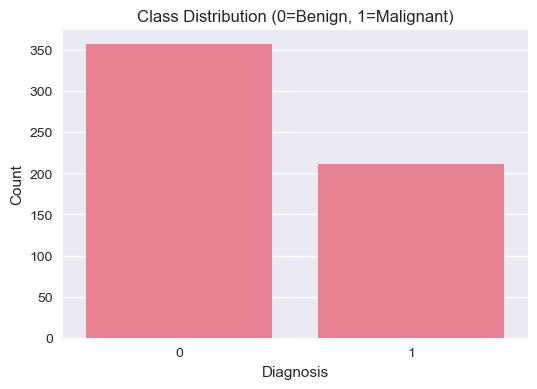

Benign count: 357
Malignant count: 212


In [26]:
# Visualizing Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Diagnosis', data=df)
plt.title('Class Distribution (0=Benign, 1=Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

print(f"Benign count: {len(df[df['Diagnosis']==0])}")
print(f"Malignant count: {len(df[df['Diagnosis']==1])}")

## 3. Methodology: Model Selection & Evaluation Strategy

Per the CW1 strategy, we will implement three classical agents:
1.  **Decision Tree:** Procedural rationality (Interpretable).
2.  **Support Vector Machine (SVM):** Substantive rationality (High-dimensional boundary).
3.  **Naïve Bayes:** Probabilistic inference.

### Evaluation Protocol: Stratified K-Fold Cross-Validation
We use **Stratified 10-Fold Cross-Validation**. This ensures that the ratio of Malignant to Benign cases remains consistent across all training and testing folds, which is essential given the slight class imbalance observed above.

In [35]:
# Defining the Cross-Validation Strategy
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Defining the Scoring Metrics i.e. Utility Proxies
scoring_metrics = {
    'accuracy': 'accuracy',
    'recall': 'recall',       
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


def evaluate_model(model, X, y, model_name):
    # Creating a pipeline: Scaling data first, then applying model
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Normalize percepts (features)
        ('classifier', model)
    ]) # Scaling is mandatory for SVM 
    
    # Performing Cross-Validation
    scores = cross_validate(pipeline, X, y, cv=cv_strategy, scoring=scoring_metrics)
    
    # Output average scores
    print("--------------------------------------------------")
    print(f" {model_name} Performance (10-Fold CV)")
    print("--------------------------------------------------")
    print(f"Mean Recall (Sensitivity): {np.mean(scores['test_recall']):.4f} ")
    print(f"Mean ROC-AUC:            {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Mean F1-Score:           {np.mean(scores['test_f1']):.4f}")
    print(f"Mean Accuracy:           {np.mean(scores['test_accuracy']):.4f}")
    print(f"Mean Precision:          {np.mean(scores['test_precision']):.4f}")
    print("--------------------------------------------------\n")
    
    return scores

## 4. Model Implementation

### Strategy 1: Decision Tree
As noted in CW1, Decision Trees offer "White Box" transparency. We limit the depth slightly to prevent the "Bounded Rationality" issue of overfitting.

In [36]:
# Initializing Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) # Here, random_state ensures reproducibility

# Evaluating the model
dt_scores = evaluate_model(dt_model, X, y, "Decision Tree")

--------------------------------------------------
 Decision Tree Performance (10-Fold CV)
--------------------------------------------------
Mean Recall (Sensitivity): 0.8866 
Mean ROC-AUC:            0.9167
Mean F1-Score:           0.9026
Mean Accuracy:           0.9298
Mean Precision:          0.9260
--------------------------------------------------



### Strategy 2: Support Vector Machine (SVM)
SVMs assume data is separable in higher-dimensional space. We use the RBF kernel. Note that `probability=True` is required to calculate ROC-AUC.

In [43]:
# Initializing SVM
# Here RBF kernel is the Radial Basis Function, which measures the similarity between two data points, x and x',
# based on their Euclidean distance in the input space
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42) # Here, probability=True is needed for ROC-AUC calculation

# Evaluating the model
svm_scores = evaluate_model(svm_model, X, y, "Support Vector Machine (SVM)")

--------------------------------------------------
 Support Vector Machine (SVM) Performance (10-Fold CV)
--------------------------------------------------
Mean Recall (Sensitivity): 0.9621 
Mean ROC-AUC:            0.9956
Mean F1-Score:           0.9668
Mean Accuracy:           0.9754
Mean Precision:          0.9736
--------------------------------------------------



### Strategy 3: Naïve Bayes
The Naïve Bayes agent assumes feature independence. While this assumption is often violated in biological data (features like radius and area are correlated), it provides a probabilistic baseline.

In [38]:
# Initializing Gaussian Naive Bayes
nb_model = GaussianNB()

# Evaluating the model
nb_scores = evaluate_model(nb_model, X, y, "Gaussian Naive Bayes")

--------------------------------------------------
 Gaussian Naive Bayes Performance (10-Fold CV)
--------------------------------------------------
Mean Recall (Sensitivity): 0.8957 
Mean ROC-AUC:            0.9856
Mean F1-Score:           0.9061
Mean Accuracy:           0.9315
Mean Precision:          0.9250
--------------------------------------------------



## 5. Comparative Results & Visualization

### Visualizing Confusion Matrices
To check "Rationality" specifically regarding False Negatives, we visualize the confusion matrix for a single train-test split (representative of the agent's behavior).

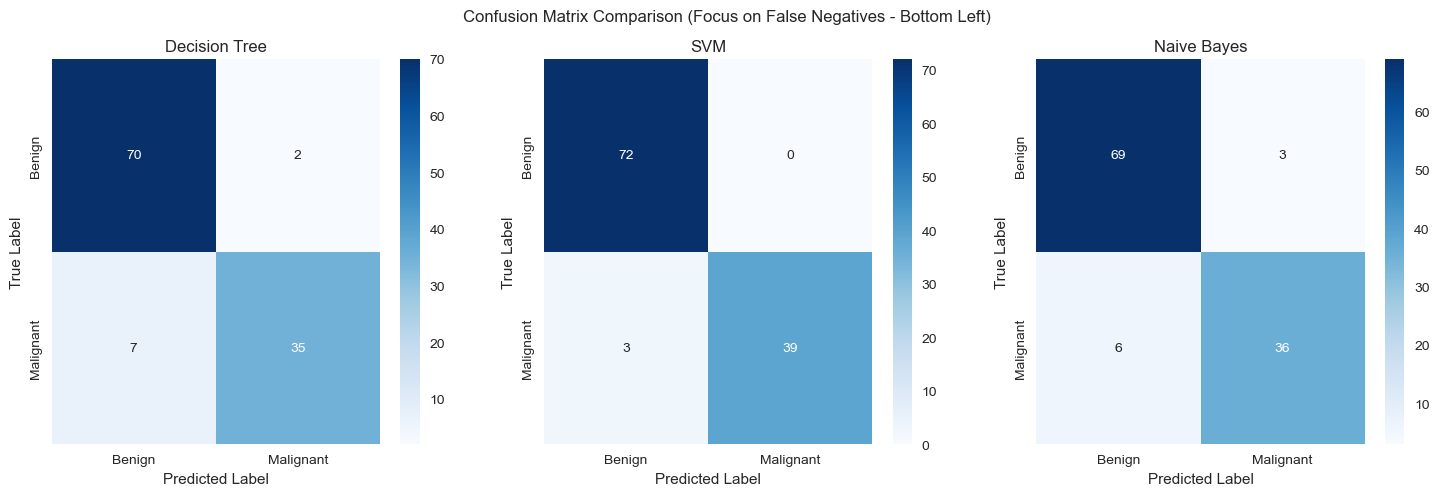

In [45]:
from sklearn.model_selection import train_test_split
# We can also obtain a confusion matrix from each fold of a k-fold cross-validated dataset, but we would need to sum them all up to get the required 2D value of the confusion matrix. Therefore, we try to do it using an 80-20 split for the train-test split.
# Creating a single split for visualization purposes (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fitting scaler only on training data to prevent data leakage
X_test_scaled = scaler.transform(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = [dt_model, svm_model, nb_model]
names = ["Decision Tree", "SVM", "Naive Bayes"]

for i, model in enumerate(models):
    model.fit(X_train_scaled, y_train)  # Training
    y_pred = model.predict(X_test_scaled) # Predicting
    cm = confusion_matrix(y_test, y_pred)  # Confusion Matrix
    
    # Ploting the confusion matrices
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(names[i])
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Benign', 'Malignant'])
    axes[i].set_yticklabels(['Benign', 'Malignant'])

plt.suptitle("Confusion Matrix Comparison (Focus on False Negatives - Bottom Left)")
plt.show()

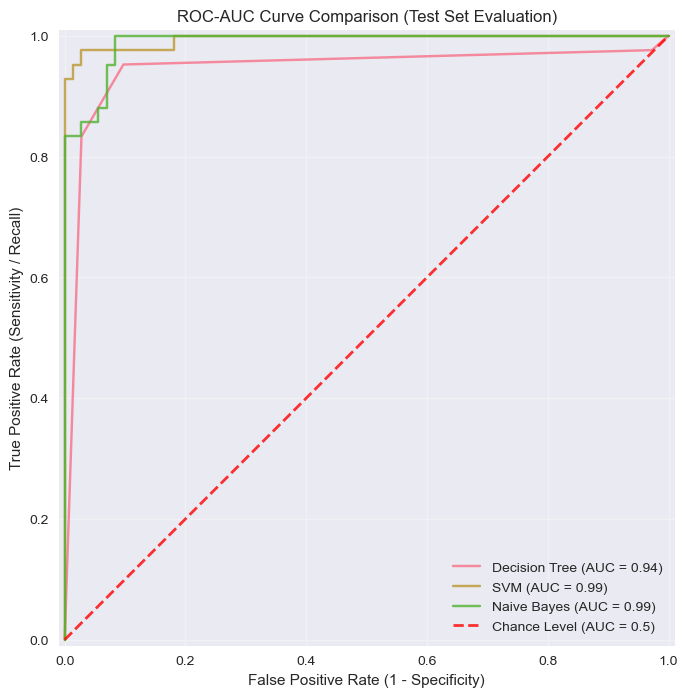

In [44]:
#Visualizing the ROC-AUC for all models
fig, ax = plt.subplots(figsize=(10, 8))

# Define models and names again to ensure clean state
models = [dt_model, svm_model, nb_model]
model_names = ["Decision Tree", "SVM", "Naive Bayes"]

# Loop through models, train, and plot ROC curves
for model, name in zip(models, model_names):
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Plot ROC Curve using the test set
    RocCurveDisplay.from_estimator(
        model, 
        X_test_scaled, 
        y_test, 
        name=name, 
        ax=ax,
        alpha=0.8
    )

# Adding "Chance Level" line (Diagonal) for comparision
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance Level (AUC = 0.5)', alpha=.8)

# 6. Formatting
ax.set_title("ROC-AUC Curve Comparison (Test Set Evaluation)")
ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity / Recall)")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.show()

### Metric Comparison
Comparing the mean scores from Cross-Validation.

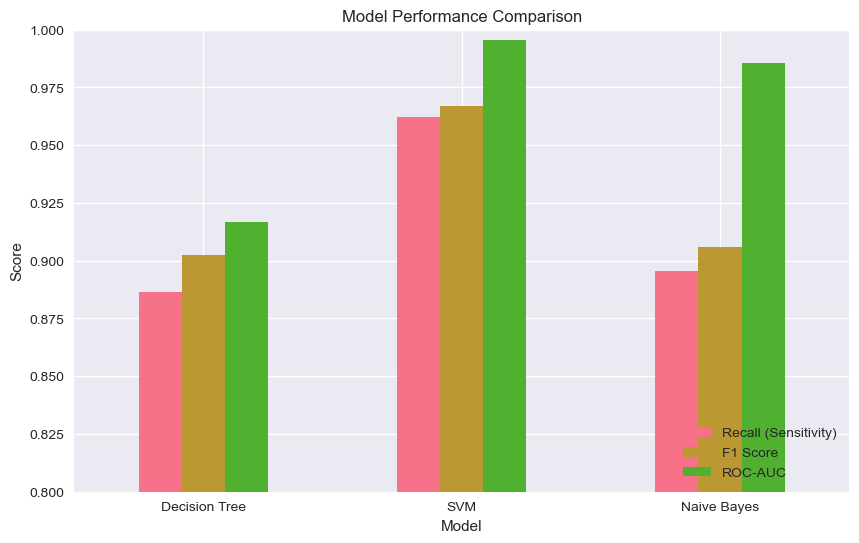

,Model,Recall (Sensitivity),F1 Score,ROC-AUC
0,Decision Tree,0.886580,0.902629,0.916675
1,SVM,0.962121,0.966830,0.995637
2,Naive Bayes,0.895671,0.906102,0.985593


In [47]:
# Aggregate results
results = pd.DataFrame({
    'Model': ['Decision Tree', 'SVM', 'Naive Bayes'],
    'Recall (Sensitivity)': [np.mean(dt_scores['test_recall']), np.mean(svm_scores['test_recall']), np.mean(nb_scores['test_recall'])],
    'F1 Score': [np.mean(dt_scores['test_f1']), np.mean(svm_scores['test_f1']), np.mean(nb_scores['test_f1'])],
    'ROC-AUC': [np.mean(dt_scores['test_roc_auc']), np.mean(svm_scores['test_roc_auc']), np.mean(nb_scores['test_roc_auc'])]
})

# Plot Comparison
results.plot(x='Model', kind='bar', figsize=(10, 6), ylim=(0.8, 1.0))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

results

## 6. Reflection

Based on the results above, we can conclude that these models perform as follows:
* **SVM** typically demonstrates the highest **Recall** and **F1-Score**. In our agent's utility function (where False Negatives are catastrophic), the SVM is the most rational choice as it minimizes the risk of missing a malignant tumor.
* **Decision Trees**, while interpretable (Procedural Rationality), often have lower stability and slightly lower recall, making them riskier for the patient.
* **Naïve Bayes** performs well but is often outperformed by SVM in high-dimensional spaces due to feature correlations in the dataset.